In [26]:
import datetime
import pytz
import numpy as np
import pandas as pd
import time

In [2]:
tsla_df = pd.read_csv('../data/raw/tsla_stock_price.csv')\
                        .drop('Unnamed: 0',axis='columns')
elon_df = pd.read_csv('../data/raw/elonmusk.csv')\
                        .drop('Unnamed: 0',axis='columns')
anomalies_df = pd.read_csv(\
            '../data/processed/anomalyandstock_tagged_tweet_features.csv')\
            .drop('Unnamed: 0',axis='columns')
tsla_df['DateTime'] = pd.to_datetime(tsla_df['DateTime'])
elon_df['Time'] = pd.to_datetime(elon_df['Time'])
anomalies_df['Time'] = pd.to_datetime(anomalies_df['Time'])
anomaly_only_df = anomalies_df[anomalies_df['anomalous']!=0.]
no_anomaly_df = anomalies_df[anomalies_df['anomalous']!=1.]

In [146]:
poslim = .2
neglim = .2
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
sell_delay = datetime.timedelta(days=1)
buy_delay = datetime.timedelta(days=1)
init_position = 5000.
init_capital = 5000.

In [205]:
datetime.datetime.today()

datetime.datetime(2020, 6, 4, 13, 34, 7, 696530)

In [34]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [32]:
start_date+sell_delay

datetime.datetime(2012, 1, 2, 0, 0, tzinfo=<UTC>)

In [35]:
nearest(tsla_df['DateTime'],start_date)

Timestamp('2011-12-30 00:00:00+0000', tz='UTC')

In [39]:
tsla_df.loc[tsla_df['DateTime'] == nearest(tsla_df['DateTime'],start_date)].index.values[0]

381

In [31]:
type(start_date)

datetime.datetime

In [19]:
type(tsla_df['DateTime'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
hold_df = pd.DataFrame()
hold_df['Time'] = tsla_df['DateTime']
hold_df.head()

,Time
0,2010-06-29 00:00:00+00:00
1,2010-06-30 00:00:00+00:00
2,2010-07-01 00:00:00+00:00
3,2010-07-02 00:00:00+00:00
4,2010-07-06 00:00:00+00:00


In [145]:
anomaly_only_df['Time'].iloc[0] < start_date
true_start_date = nearest(tsla_df['DateTime'],start_date)
start_index = tsla_df.loc[tsla_df['DateTime'] 
                                    == true_start_date].index[0]
print(start_index)

1891


In [49]:
hold_df['position'] = (tsla_df['Open']/tsla_df['Open'].iloc[0])*init_position
hold_df.tail()

,Time,position
5693,2020-06-03 19:35:00+00:00,232821.044922
5694,2020-06-03 19:40:00+00:00,233044.738770
5695,2020-06-03 19:45:00+00:00,233081.584730
5696,2020-06-03 19:50:00+00:00,233081.584730
5697,2020-06-03 19:55:00+00:00,232460.439582


In [99]:
sell_date = tsla_df.loc[tsla_df['DateTime'] == anomaly_only_df['stock_time'].iloc[20]]['DateTime'] + sell_delay
print(anomaly_only_df['stock_time'].iloc[20])
print(sell_date.iloc[0])
tsla_df.loc[tsla_df['DateTime'] == sell_date.iloc[0]].index[0]

2012-11-23 00:00:00+00:00
2012-11-24 00:00:00+00:00


IndexError: index 0 is out of bounds for axis 0 with size 0

In [147]:
hold_df = pd.DataFrame() #initialize 
buy_and_sell_df = pd.DataFrame() #initialize
true_start_date = nearest(tsla_df['DateTime'],start_date) #the closest date with a stock price
start_index = tsla_df.loc[tsla_df['DateTime'] == true_start_date].index[0] #the index of true_start_date
hold_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
buy_and_sell_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
# Position growth scales with Tesla stock price
hold_df['num_shares'] = init_position/tsla_df['Open'].iloc[start_index]
hold_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                       /tsla_df['Open'].iloc[start_index])*init_position
buy_and_sell_df['num_shares'] = init_position/tsla_df['Open'].iloc[start_index]
buy_and_sell_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                               *buy_and_sell_df['num_shares'])
# Capital growth only changes as a result of buy -> sell orders
hold_df['capital'] = init_capital
buy_and_sell_df['capital'] = init_capital

In [148]:
buy_and_sell_df.head()

,Time,num_shares,position,capital
381,2011-12-30 00:00:00+00:00,175.500176,5000.000000,5000.0
382,2012-01-03 00:00:00+00:00,175.500176,5078.975079,5000.0
383,2012-01-04 00:00:00+00:00,175.500176,4950.859951,5000.0
384,2012-01-05 00:00:00+00:00,175.500176,4871.884872,5000.0
385,2012-01-06 00:00:00+00:00,175.500176,4773.604774,5000.0


In [149]:
hold_df.tail()

,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,175.500176,155268.510127,5000.0
5694,2020-06-03 19:40:00+00:00,175.500176,155417.691703,5000.0
5695,2020-06-03 19:45:00+00:00,175.500176,155442.264298,5000.0
5696,2020-06-03 19:50:00+00:00,175.500176,155442.264298,5000.0
5697,2020-06-03 19:55:00+00:00,175.500176,155028.022185,5000.0


In [139]:
i=20
buy_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime']
buy_index = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]].index[0]
buy_price = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]]['Open'].values[0]
sell_date_target = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime'] + buy_delay
#the desired sell date may not be a business day
sell_date = nearest(tsla_df['DateTime'].iloc[buy_index+1:],sell_date_target.iloc[0]) 
sell_index = tsla_df.loc[tsla_df['DateTime'] == sell_date].index[0]
sell_price = tsla_df.loc[tsla_df['DateTime'] == sell_date]['Open'].values[0]
frac_change = sell_price/buy_price #the fractional change in our captial from the transactionuy
print (frac_change)
buy_and_sell_df['capital'].iloc[sell_index:] *= frac_change
buy_and_sell_df.tail()

0.9846625766871165


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,16.025641,14178.204659,4923.312883
5694,2020-06-03 19:40:00+00:00,16.025641,14191.827040,4923.312883
5695,2020-06-03 19:45:00+00:00,16.025641,14194.070865,4923.312883
5696,2020-06-03 19:50:00+00:00,16.025641,14194.070865,4923.312883
5697,2020-06-03 19:55:00+00:00,16.025641,14156.244718,4923.312883


In [157]:
i=20
sell_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime']
print(anomaly_only_df['stock_time'].iloc[i])
print(sell_date)
sell_index = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]].index[0]
sell_price = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]]['Open'].values[0]
print(sell_price)
buy_date_target = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime'] + sell_delay
print(buy_date_target)
#the desired sell date may not be a business day
buy_date = nearest(tsla_df['DateTime'].iloc[sell_index+1:],buy_date_target.iloc[0]) 
print(buy_date)
#adjust sell_index to buy_and_sell index coords with (- start_index)
buy_index = tsla_df.loc[tsla_df['DateTime'] == buy_date].index[0] - start_index
buy_price = tsla_df.loc[tsla_df['DateTime'] == buy_date]['Open'].values[0]
print(buy_price)
#the change in the number of shares, again adjust sell_index to buy_and_sell 
#index coords with (- start_index) 
new_num_shares = sell_price*(buy_and_sell_df['num_shares']
                             .iloc[sell_index-start_index])/buy_price 
buy_and_sell_df['num_shares'].iloc[buy_index:] = new_num_shares
buy_and_sell_df['position'].iloc[buy_index:]  = new_num_shares*tsla_df['Open']\
                                                                .iloc[buy_index+start_index:]
buy_and_sell_df.tail()

2012-11-23 00:00:00+00:00
606   2012-11-23 00:00:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]
32.6
606   2012-11-24 00:00:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]
2012-11-26 00:00:00+00:00
32.1


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,178.233823,157687.022746,5000.0
5694,2020-06-03 19:40:00+00:00,178.233823,157838.528022,5000.0
5695,2020-06-03 19:45:00+00:00,178.233823,157863.483369,5000.0
5696,2020-06-03 19:50:00+00:00,178.233823,157863.483369,5000.0
5697,2020-06-03 19:55:00+00:00,178.233823,157442.788886,5000.0


In [176]:
anomaly_only_df['Time'][40]

Timestamp('2011-12-31 13:06:23+0000', tz='UTC')

In [177]:
for i in anomaly_only_df.index:
    print (anomaly_only_df['Time'][i])

2011-12-01 09:55:11+00:00
2011-12-31 13:06:23+00:00
2012-02-25 18:36:12+00:00
2012-03-20 21:05:26+00:00
2012-05-03 18:15:01+00:00
2012-05-03 18:22:41+00:00
2012-05-03 18:27:19+00:00
2012-05-22 07:34:32+00:00
2012-05-22 07:43:41+00:00
2012-05-22 10:31:20+00:00
2012-05-22 10:38:25+00:00
2012-05-22 12:27:20+00:00
2012-05-23 15:09:40+00:00
2012-05-24 06:23:53+00:00
2012-05-24 18:15:19+00:00
2012-05-25 20:23:00+00:00
2012-05-31 14:21:33+00:00
2012-05-31 14:31:25+00:00
2012-05-31 15:48:16+00:00
2012-07-12 14:57:32+00:00
2012-11-22 16:32:13+00:00
2012-12-02 21:12:03+00:00
2012-12-12 20:06:11+00:00
2013-02-04 03:06:02+00:00
2013-03-02 20:58:29+00:00
2013-03-08 14:37:27+00:00
2013-03-09 19:55:35+00:00
2013-04-02 16:19:41+00:00
2013-04-02 17:49:11+00:00
2013-07-28 02:47:17+00:00
2014-02-14 00:58:23+00:00
2014-04-29 08:19:25+00:00
2016-03-09 18:37:34+00:00
2016-04-03 22:10:23+00:00
2016-06-09 02:14:23+00:00
2017-02-19 14:58:24+00:00
2017-03-28 10:20:38+00:00
2017-03-28 16:58:36+00:00
2017-04-28 2

In [218]:
from numba import jit
poslim = .2
neglim = .2
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
sell_delay = datetime.timedelta(days=1)
buy_delay = datetime.timedelta(days=1)
init_position = 5000.
init_capital = 5000.
#@jit(nopython=False)
def asset_strategy_calculation(poslim,neglim,init_position,init_capital,
                                buy_delay,sell_delay,start_date,
                                anomaly_only_df,tsla_df):
    """The buying and selling strategy implementing tweet inforation"""
    hold_df = pd.DataFrame() #initialize 
    buy_and_sell_df = pd.DataFrame() #initialize
    #the closest date with a stock price
    true_start_date = nearest(tsla_df['DateTime'],start_date) 
    #the index of true_start_date
    start_index = tsla_df.loc[tsla_df['DateTime'] == true_start_date].index[0]
    hold_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
    buy_and_sell_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
    # Position growth scales with Tesla stock price
    hold_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                           /tsla_df['Open'].iloc[start_index])*init_position
    # buy_and sell_df needs to track the number of shares held
    buy_and_sell_df['num_shares'] = init_position/tsla_df['Open']\
                                                    .iloc[start_index]
    # and the value of those shares
    buy_and_sell_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                                   *buy_and_sell_df['num_shares'])
    # Capital growth only changes as a result of buy -> sell orders
    hold_df['capital'] = init_capital
    buy_and_sell_df['capital'] = init_capital
    # Iterate over the anomalies and make trades based on input variables
    for i in anomaly_only_df.index:# we only trade based on tweet anomalies
        #iterate forward through time with the index of anomaly_only_df
        if anomaly_only_df['Time'][i] < start_date: 
            #this anomaly happened before we started trading
            pass
        elif anomaly_only_df['text_compound'][i] < poslim and \
                anomaly_only_df['text_compound'][i] > neglim : 
            #neutral anomaly, do nothing
            pass
        elif anomaly_only_df['text_compound'][i] >= poslim : 
            # buy first then sell
            buy_date = tsla_df.loc[tsla_df['DateTime'] \
                                   == anomaly_only_df['stock_time'][i]]\
                                   ['DateTime']
            buy_index = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    .index[0]
            buy_price = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    ['Open'].values[0]
            sell_date_target = tsla_df.loc[tsla_df['DateTime'] 
                                           == anomaly_only_df['stock_time'][i]\
                                           ]['DateTime'] + buy_delay
            #the desired sell date may not be a business day
            sell_date = nearest(tsla_df['DateTime'].iloc[buy_index+1:],\
                                                    sell_date_target.iloc[0]) 
            #adjust sell_index to buy_and_sell index units with (- start_index)
            sell_index = tsla_df.loc[tsla_df['DateTime'] == sell_date].\
                                                        index[0] - start_index
            sell_price = tsla_df.loc[tsla_df['DateTime'] == sell_date]\
                                                            ['Open'].values[0]
            #the fractional change in our captial from the transaction
            frac_change = sell_price/buy_price 
            buy_and_sell_df['capital'].iloc[sell_index:] *= frac_change
        elif anomaly_only_df['text_compound'][i] <= -neglim : 
            # sell first then buy
            sell_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'][i]]['DateTime']
            sell_index = tsla_df.loc[tsla_df['DateTime'] 
                                    == anomaly_only_df['stock_time'][i]]\
                                                                .index[0]
            sell_price = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    ['Open'].values[0]
            buy_date_target = tsla_df.loc[tsla_df['DateTime'] \
                                         == anomaly_only_df['stock_time'][i]]\
                                         ['DateTime'] + sell_delay
            #the desired sell date may not be a business day
            buy_date = nearest(tsla_df['DateTime'].iloc[sell_index+1:],\
                               buy_date_target.iloc[0]) 
            #adjust sell_index to buy_and_sell index units with (- start_index)
            buy_index = tsla_df.loc[tsla_df['DateTime'] == buy_date].index[0]\
                        - start_index
            buy_price = tsla_df.loc[tsla_df['DateTime'] == buy_date]['Open']\
                                    .values[0]
            #the change in the number of shares, again adjust sell_index to 
            #buy_and_sell index coords with (- start_index) 
            new_num_shares = sell_price*(buy_and_sell_df['num_shares']\
                                       .iloc[sell_index-start_index])/buy_price 
            #record the new shares
            buy_and_sell_df['num_shares'].iloc[buy_index:] = new_num_shares 
            #compute the new position
            buy_and_sell_df['position'].iloc[buy_index:] = new_num_shares*\
                                tsla_df['Open'].iloc[buy_index+start_index:]
            
    hold_df['total'] = hold_df['position']+hold_df['capital']
    buy_and_sell_df['total'] = buy_and_sell_df['position']+\
                               buy_and_sell_df['capital']
    #relative performance
    hold_df['relative'] = hold_df['total']/hold_df['total']
    buy_and_sell_df['relative'] = buy_and_sell_df['total']/\
                                  hold_df['total']
    return buy_and_sell_df,hold_df 

In [219]:
%%time
strat_df,hold_df = asset_strategy_calculation(poslim,neglim,init_position,init_capital,\
                                buy_delay,sell_delay,start_date,\
                                anomaly_only_df,tsla_df)

CPU times: user 7.43 s, sys: 65.1 ms, total: 7.5 s
Wall time: 7.6 s


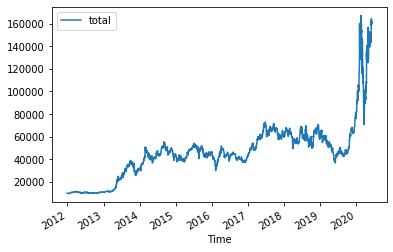

In [200]:
hold_df.plot(x='Time',y='total')

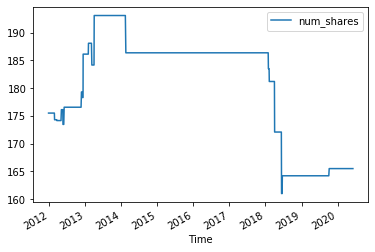

In [202]:
strat_df.plot(x='Time',y='num_shares')

In [203]:
(hold_df[['Time','total']]/strat_df[['Time','total']]).plot('Time','total')

TypeError: cannot perform __truediv__ with this index type: DatetimeArray